In [83]:
metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
image_folder_path = '/kaggle/input/isic-2024-challenge/train-image/image'
test_hdf5_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
output_dir = '/kaggle/working/extracted_images'

In [84]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import h5py
import io
from io import BytesIO
import random
import cv2
from torchvision import transforms
import shutil

In [110]:
metadata = pd.read_csv(metadata_path, low_memory=False)
metadata['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [111]:
positive = metadata[metadata['target'] == 1]
negative = metadata[metadata['target'] == 0].sample(n=1000, random_state=1)
downsampled_data = pd.concat([positive, negative])
downsampled_data['target'].value_counts()

target
0    1000
1     393
Name: count, dtype: int64

---


In [112]:
def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 12, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(image, thresh, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    return inpainted
    
def preprocess_image(image, output_size=(224, 224)):
    image_np = np.array(image)
    hair_removed_image = remove_hair(image_np)
    hair_removed_image = Image.fromarray(hair_removed_image)
    return hair_removed_image

In [113]:
train_data, test_data = train_test_split(downsampled_data, test_size=0.2, random_state=2)

class ImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):   
        img_name = os.path.join(self.image_dir, f"{self.dataframe.iloc[idx]['isic_id']}.jpg")
        image = Image.open(img_name)
        image = preprocess_image(image)
        label = self.dataframe.iloc[idx]['target']
        if self.transform:
            image = self.transform(image)
        return image, label

In [114]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data, test_data = train_test_split(downsampled_data, test_size=0.2, random_state=2)

train_dataset = ImageDataset(train_data, image_folder_path, transform=transform)
test_dataset = ImageDataset(test_data, image_folder_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


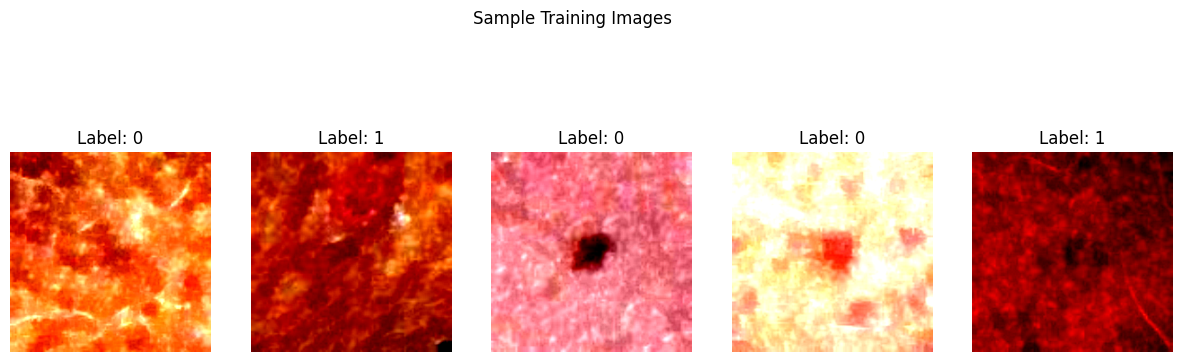

In [117]:
def show_images(images, labels, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (image, label) in enumerate(zip(images, labels)):
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy() 
        else:
            image = image.transpose(1, 2, 0)
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

sample_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
images, labels = next(iter(sample_loader))
images_np = images.cpu().numpy()
show_images(images_np, labels, 'Sample Training Images')


In [118]:
model = models.mobilenet_v2(weights='IMAGENET1K_V2')

for param in model.parameters():
    param.requires_grad = False 

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model.classifier.add_module("Sigmoid", nn.Sigmoid())

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
criterion = nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [120]:
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/1, Loss: 0.631436198098319


In [122]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, zero_division=1))


Accuracy: 0.7527
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86       210
         1.0       1.00      0.00      0.00        69

    accuracy                           0.75       279
   macro avg       0.88      0.50      0.43       279
weighted avg       0.81      0.75      0.65       279



In [95]:
os.makedirs(output_dir, exist_ok=True)
with h5py.File(test_hdf5_path, 'r') as hdf_file:
    for key in hdf_file.keys():
        dataset = hdf_file[key]
        img_data = dataset[()]
        img_data = np.frombuffer(img_data, dtype=np.uint8)
        img = Image.open(io.BytesIO(img_data))
        img.save(os.path.join(output_dir, f"{key}.jpg"))


In [96]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img).transpose(2, 0, 1)  # Convert to (C, H, W)
    img_tensor = torch.tensor(img_array).float().unsqueeze(0)  # Add batch dimension
    return img_tensor.to(device)


In [97]:
isic_ids = []
predictions = []
for image_filename in os.listdir(output_dir):
    if image_filename.endswith('.jpg'):
        isic_id = os.path.splitext(image_filename)[0]
        image_path = os.path.join(output_dir, image_filename)
        image_tensor = preprocess_image(image_path)
        with torch.no_grad():
            output = model(image_tensor).squeeze()
            prob = torch.sigmoid(output).item()
        isic_ids.append(isic_id)
        predictions.append(prob)

In [46]:
submission_df = pd.DataFrame({
    'isic_id': isic_ids,
    'target': predictions
})
submission_file_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file_path, index=False)
print(f"Submission file created at: {submission_file_path}")

Submission file created at: /kaggle/working/submission.csv
